# Bayesian FDA

In [60]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib

In [46]:
# Dimension of data
D = 2

# Number of training data for each class
N1 = 2
N2 = 2
N = N1+N2

matrixSize = 2
A = np.random.rand(matrixSize, matrixSize)

# Covariance of each class
sig = np.dot(A, A.transpose())

# Mean of each class
true_mean1 = np.array([2, 0])
true_mean2 = np.array([-2, 0])

In [47]:
# Samples
samples1 = np.random.multivariate_normal(true_mean1, sig, N1).T
samples2 = np.random.multivariate_normal(true_mean2, sig, N2).T

# Sampled mean of each class 
m = (np.sum(samples1, axis=1).reshape(D, 1)+np.sum(samples2, axis=1).reshape(D, 1))/N
m1 = (np.sum(samples1, axis=1).reshape(D, 1))/N1
m2 = (np.sum(samples2, axis=1).reshape(D, 1))/N2

In [48]:
# Centralize
X1 = np.array(samples1 - np.repeat(m1, N1, 1))
X2 = np.array(samples2 - np.repeat(m2, N2, 1))
X  = np.concatenate((samples1, samples2), axis=1) - np.repeat(m, N, 1)

# within-class & between-class covariance
Sw =  X1 @ X1.T/N1 + X2 @ X2.T/N2
Sb = np.matmul(np.add(m1, -m2), np.add(m1, -m2).T) * (N1*N2/N)

Sw_inv = np.linalg.inv(Sw+Sb)

In [49]:
gamma = .1

# Classification boundary
w = N*Sw_inv @ (m1 - m2)
w_b = N*np.linalg.inv(Sw+Sb+np.identity(2)*gamma)@(m1-m2)

y = -w[0]/w[1]*(np.linspace(-5, 5, 100))+(w.T @ (m1+m2)).reshape(-1)/(2*w[1])
w = w_b
y2 = -w[0]/w[1]*(np.linspace(-5, 5, 100))+(w.T @ (m1+m2)).reshape(-1)/(2*w[1])

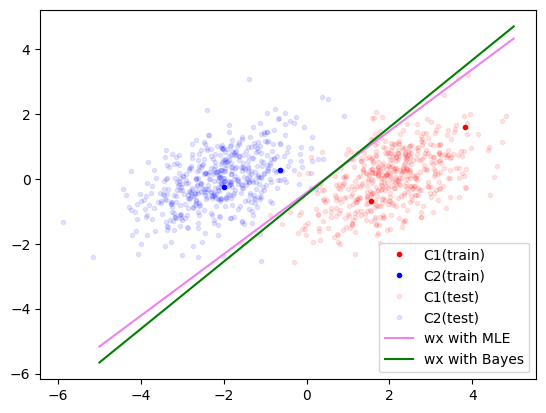

In [50]:
# Test samples
N1 = 500
N2 = 500
testSamples1 = np.random.multivariate_normal(true_mean1, sig, N1).T
testSamples2 = np.random.multivariate_normal(true_mean2, sig, N2).T

# Plot
plt.plot(samples1[0, :], samples1[1, :], 'r.', label="C1(train)")
plt.plot(samples2[0, :], samples2[1, :], 'b.', label="C2(train)")

plt.plot(testSamples1[0, :],testSamples1[1, :], 'r.', label="C1(test)", alpha=.1)
plt.plot(testSamples2[0, :],testSamples2[1, :], 'b.', label="C2(test)", alpha=.1)

plt.plot(np.linspace(-5, 5, 100), y, color='violet', linestyle='-', label='wx with MLE')
plt.plot(np.linspace(-5, 5, 100), y2, 'g-', label='wx with Bayes')

plt.legend()
plt.show()

# Kernel extension of bayesian FDA

Equal to Gaussian Process

Gaussian kernel used

In [51]:
# Gaussian kernel
def GaussianKernel(X1, X2, sig=1.):
    dist_sqs = np.sum(X1**2, axis=1).reshape([-1,1]) + \
        np.sum(X2**2, axis=1).reshape([1,-1]) - \
        2*np.matmul(X1, X2.T)
    K = np.exp(-0.5*dist_sqs/sig**2)
    return K

In [52]:
# Observations
tr_xs1 = np.random.multivariate_normal(true_mean1, sig, N1).reshape(-1, 2)
tr_xs2 = np.random.multivariate_normal(true_mean2, sig, N2).reshape(-1, 2)

tr_xs = np.concatenate((tr_xs1,tr_xs2), axis=0)
ys1 = np.full((N1,),  N/N1)
ys2 = np.full((N2,), -N/N2)
ys  = np.concatenate((ys1, ys2), axis=0)

In [53]:
n_sample = 100

# Underlier
xs1 = np.linspace(-10, 10, n_sample)
xs2 = np.linspace(-10, 10, n_sample)
xs = np.transpose([np.tile(xs1, n_sample), np.repeat(xs2, n_sample)])
xs1, xs2 = np.meshgrid(xs1, xs2)

In [54]:
K = GaussianKernel(tr_xs, tr_xs)  # covariances
K = K + np.identity(K.shape[0])

k = GaussianKernel(tr_xs, xs)

invK = np.linalg.inv(K)

m_fun = np.matmul(np.matmul(k.T, invK), ys).reshape(n_sample, n_sample)
k_fun = GaussianKernel(xs, xs) - np.matmul(np.matmul(k.T, invK), k)
var_test = np.diag(k_fun)

Text(0.5, 1.0, 'mean')

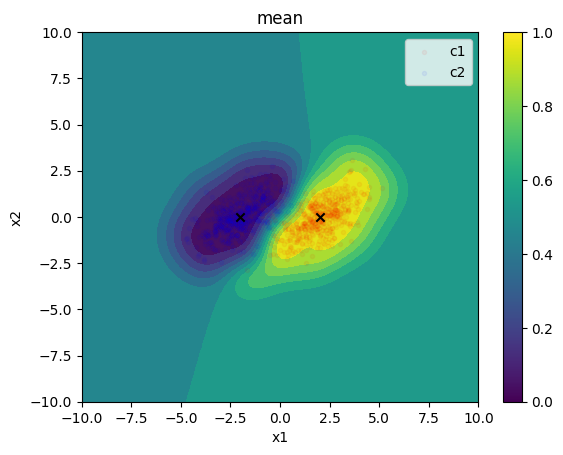

In [63]:
# Plot mean
cm = matplotlib.colormaps['viridis']

plt.contourf(xs1, xs2, m_fun, levels=16,cmap=cm)

plt.scatter(tr_xs1[:,0], tr_xs1[:, 1], color='r', marker='.', label='c1',alpha=0.05)

plt.scatter(tr_xs2[:,0], tr_xs2[:, 1], color='b', marker='.', label='c2',alpha=0.05)
plt.scatter(true_mean1[0], true_mean1[1], color='black', marker='x')
plt.scatter(true_mean2[0], true_mean2[1], color='black', marker='x')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-10)
plt.ylim(-10)
plt.colorbar()
plt.legend()
plt.title("mean")


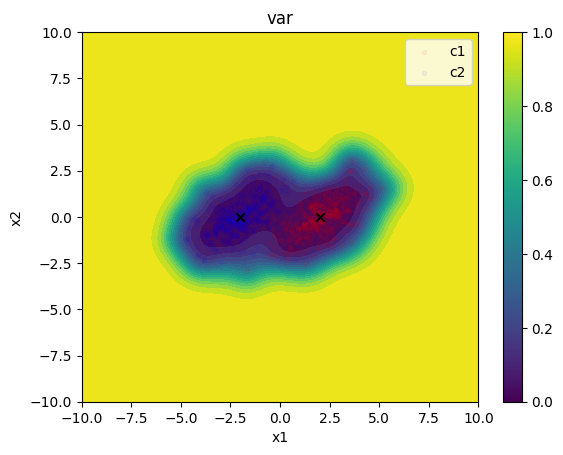

In [64]:
plt.figure()
plt.contourf(xs1, xs2, var_test.reshape(n_sample, n_sample), levels=16,cmap=cm)
plt.scatter(tr_xs1[:,0], tr_xs1[:, 1], color='r', marker='.', label='c1',alpha=0.05)
plt.scatter(tr_xs2[:,0], tr_xs2[:, 1], color='b', marker='.', label='c2',alpha=0.05)
plt.scatter(true_mean1[0], true_mean1[1], color='black', marker='x')
plt.scatter(true_mean2[0], true_mean2[1], color='black', marker='x')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-10)
plt.ylim(-10)
plt.colorbar()
plt.legend()
plt.title("var")
plt.show()